In [2]:
import numpy as np
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt

from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
from tslearn.utils import ts_size

In [3]:
# Import the HAR dataset
x_train_file = open('UCI HAR Dataset/train/Inertial Signals/body_acc_z_train.txt', 'r')
y_train_file = open('UCI HAR Dataset/train/y_train.txt', 'r')

x_test_file = open('UCI HAR Dataset/test/Inertial Signals/body_acc_z_test.txt', 'r')
y_test_file = open('UCI HAR Dataset/test/y_test.txt', 'r')

# Create empty lists
x_train = []
y_train = []
x_test = []
y_test = []

# Mapping table for classes
labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
          4:'SITTING', 5:'STANDING', 6:'LAYING'}

# Loop through datasets
for x in x_train_file:
    x_train.append([float(ts) for ts in x.split()])
    
for y in y_train_file:
    y_train.append(int(y.rstrip('\n')))
    
for x in x_test_file:
    x_test.append([float(ts) for ts in x.split()])
    
for y in y_test_file:
    y_test.append(int(y.rstrip('\n')))
    
take_first = 500
# Convert to numpy for efficiency
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [4]:
x_train[0].shape

(128,)

In [4]:
mask = np.isin(y_train, [1, 5])
x_train = x_train[mask]
y_train = y_train[mask]
print(y_train)

[5 5 5 ... 1 1 1]


In [5]:
msk = np.isin(y_test, [1, 5])
print(y_test.shape)
print(msk.shape)
print(x_test.shape)
x_test = x_test[msk]
y_test = y_test[msk]

(2947,)
(2947,)
(2947, 128)


In [6]:
# Normalize each of the timeseries in the Trace dataset
x_train = TimeSeriesScalerMinMax().fit_transform(x_train)
x_test = TimeSeriesScalerMinMax().fit_transform(x_test)

In [7]:
# Get statistics of the dataset
n_ts, ts_sz = x_train.shape[:2]
n_classes = len(set(y_train))
print(n_classes)
print(n_ts, ts_sz)

2
2600 128


In [8]:
help(grabocka_params_to_shapelet_size_dict)

Help on function grabocka_params_to_shapelet_size_dict in module tslearn.shapelets.shapelets:

grabocka_params_to_shapelet_size_dict(n_ts, ts_sz, n_classes, l, r)
    Compute number and length of shapelets.
    
     This function uses the heuristic from [1]_.
    
    Parameters
    ----------
    n_ts: int
        Number of time series in the dataset
    ts_sz: int
        Length of time series in the dataset
    n_classes: int
        Number of classes in the dataset
    l: float
        Fraction of the length of time series to be used for base shapelet
        length
    r: int
        Number of different shapelet lengths to use
    
    Returns
    -------
    dict
        Dictionary giving, for each shapelet length, the number of such
        shapelets to be generated
    
    Examples
    --------
    >>> d = grabocka_params_to_shapelet_size_dict(
    ...         n_ts=100, ts_sz=100, n_classes=3, l=0.1, r=2)
    >>> keys = sorted(d.keys())
    >>> print(keys)
    [10, 20]
    >>

In [9]:
# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts, ts_sz=ts_sz, n_classes=n_classes, l=0.1, r=1)
print(shapelet_sizes)

{12: 5}


In [10]:
# Define the model using parameters provided by the authors (except that we use fewer iterations here)
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes, 
                            optimizer=tf.optimizers.Adam(.01), 
                            batch_size=16, 
                            weight_regularizer=.01, 
                            max_iter=200, 
                            random_state=42,
                            verbose=1)

c:\Users\aikyn\miniconda3\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [11]:
shp_clf.fit(x_train, y_train)

Epoch 1/200
163/163 [==============================] - 1s 2ms/step - loss: 0.6808 - binary_accuracy: 0.6038 - binary_crossentropy: 0.6724
Epoch 2/200
163/163 [==============================] - 0s 1ms/step - loss: 0.6423 - binary_accuracy: 0.7092 - binary_crossentropy: 0.6231
Epoch 3/200
163/163 [==============================] - 0s 1ms/step - loss: 0.6184 - binary_accuracy: 0.7300 - binary_crossentropy: 0.5903
Epoch 4/200
163/163 [==============================] - 0s 1ms/step - loss: 0.6062 - binary_accuracy: 0.7319 - binary_crossentropy: 0.5721
Epoch 5/200
163/163 [==============================] - 0s 1ms/step - loss: 0.5970 - binary_accuracy: 0.7477 - binary_crossentropy: 0.5592
Epoch 6/200
163/163 [==============================] - 0s 1ms/step - loss: 0.5906 - binary_accuracy: 0.7488 - binary_crossentropy: 0.5511
Epoch 7/200
163/163 [==============================] - 0s 1ms/step - loss: 0.5814 - binary_accuracy: 0.7473 - binary_crossentropy: 0.5401
Epoch 8/200
163/163 [=============

LearningShapelets(batch_size=16, max_iter=200, n_shapelets_per_size={12: 5},
                  optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x000002690B414FA0>,
                  random_state=42, verbose=1, weight_regularizer=0.01)

In [21]:
# Make predictions and calculate accuracy score
pred_labels = shp_clf.predict(x_test)
print("Correct classification rate:", accuracy_score(y_test, pred_labels))
print(pred_labels[1:100])
print(y_test[1:100])

65/65 [==============================] - 0s 1ms/step
Correct classification rate: 0.8210116731517509
[5 5 5 5 5 1 5 5 5 5 5 5 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 1 1 1 1 1 1
 1 1 1 1 5 1 1 1 1 1 1 1 1 1 1 1 1 5 1 1 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 1 5 5 5 5 1 5 5 5 1 1 1 5 5 1 1 1 1 1 1 1 1 1 1 1]
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [17]:
shp_clf.shapelets_.shape

(5,)

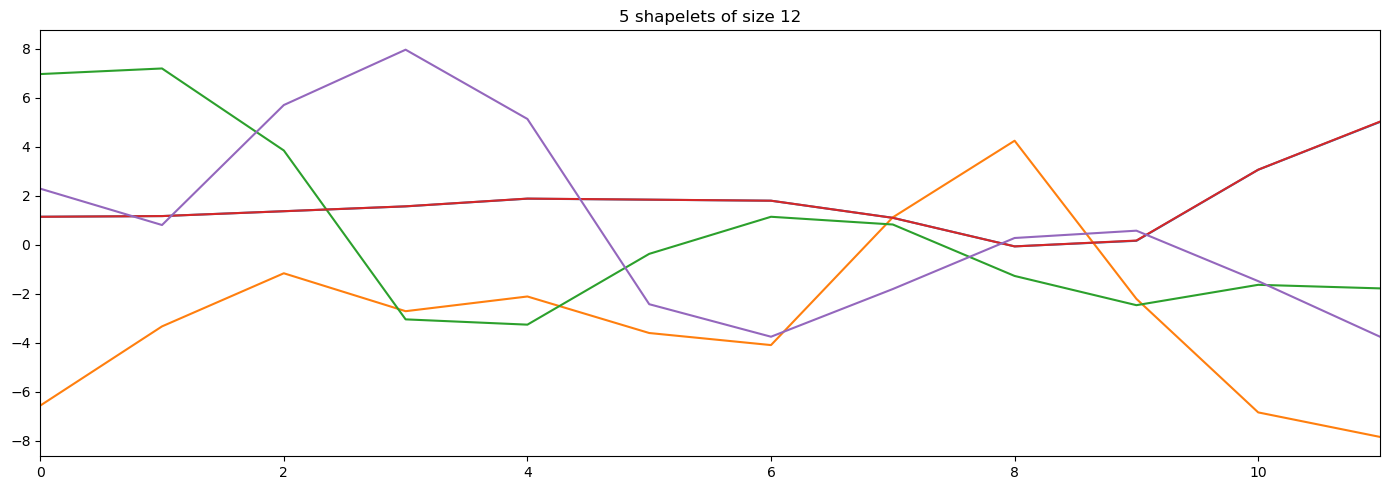

In [18]:
# Plot the different discovered shapelets
plt.figure(figsize=(14,5))
for i, sz in enumerate(shapelet_sizes.keys()):
    plt.subplot(len(shapelet_sizes), 1, i + 1)
    plt.title("%d shapelets of size %d" % (shapelet_sizes[sz], sz))
    for shp in shp_clf.shapelets_:
        if ts_size(shp) == sz:
            plt.plot(shp.ravel())
    plt.xlim([0, max(shapelet_sizes.keys()) - 1])

plt.tight_layout()
plt.show()
     

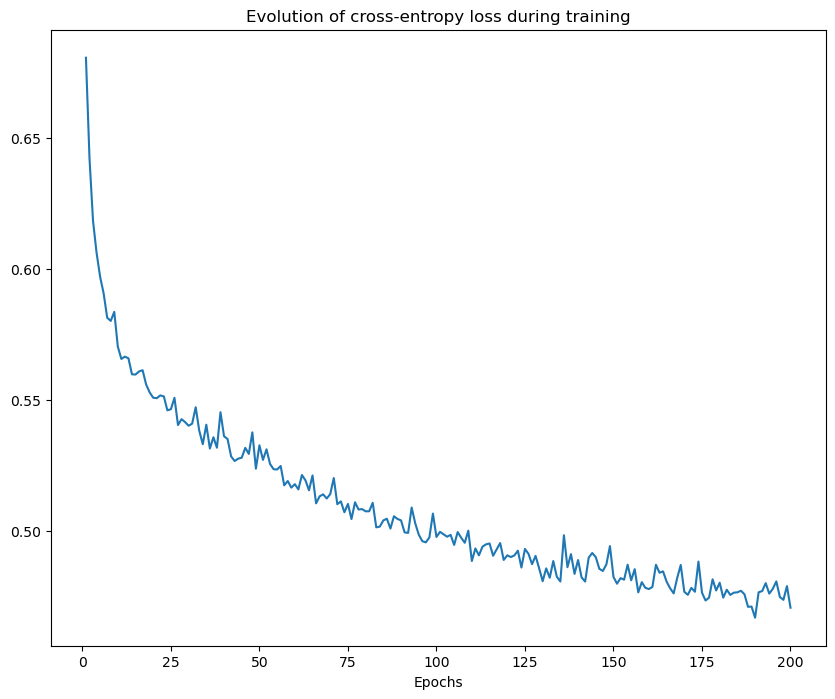

In [15]:
# The loss history is accessible via the `model_` that is a keras model
plt.figure(figsize=(10,8))
plt.plot(np.arange(1, shp_clf.n_iter_ + 1), shp_clf.history_["loss"])
plt.title("Evolution of cross-entropy loss during training")
plt.xlabel("Epochs")
plt.show()